## Feed Forward Style Transfer

In [2]:
import os, random, time
from pathlib import Path
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models, utils
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#select computation device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    USE_AMP = True
elif getattr(torch, "has_mps", False) and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    USE_AMP = False
else:
    DEVICE = torch.device("cpu")
    USE_AMP = False

print("Device:", DEVICE, "USE_AMP:", USE_AMP)

Device: cuda USE_AMP: True


In [5]:
#Hyperparameters
IMG_SIZE = 512
BATCH_SIZE = 6
NUM_EPOCHS = 12
LR = 1e-3
CONTENT_WEIGHT = 1.0
STYLE_WEIGHT = 1e6
TV_WEIGHT = 1e-6

In [6]:
#fielpaths
CONTENT_ROOT = "../../data/animals_balanced"   
STYLE_ROOT= "../../data/origami_images"
SPLIT_ROOT   = "../../data/split"   
CHECKPOINT_DIR = "./checkpoints_nststyle"
SAMPLES_DIR    = "./samples_nststyle"

for d in [SPLIT_ROOT, CHECKPOINT_DIR, SAMPLES_DIR]:
    os.makedirs(d, exist_ok=True)

TARGET_CLASS = "butterfly" #single class (inital)

for split in ['train', 'val', 'test']:
    for root in ['content', 'style']:
        path = os.path.join(SPLIT_ROOT, root, split, TARGET_CLASS)
        os.makedirs(path, exist_ok=True)
        

### VGG Configuration

In [8]:
#Vsame as NST
LAYER_INDICES = {
    'conv1_1': '0', 
    'conv1_2': '2', 
    'conv2_1': '5', 
    'conv2_2': '7',
    'conv3_1': '10', 
    'conv3_2': '12', 
    'conv3_3': '14', 
    'conv3_4': '16',
    'conv4_1': '19', 
    'conv4_2': '21', 
    'conv4_3': '23', 
    'conv4_4': '25',
    'conv5_1': '28', 
    'conv5_2': '30', 
    'conv5_3': '32', 
    'conv5_4': '34'
}

LAYER_CONFIGS = {
    'gatys': {
        'content': ['conv4_2'],
        'style': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1'],
        'style_weights': {
            'conv1_1': 1.0,
            'conv2_1': 0.8,
            'conv3_1': 0.5,
            'conv4_1': 0.3,
            'conv5_1': 0.1
        },
    }
}
ACTIVE_LAYER_CONFIG = 'gatys'


In [9]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD  = [0.229, 0.224, 0.225]

def list_images(dir_):
    return sorted([os.path.join(dir_,f) for f in os.listdir(dir_)
                   if f.lower().endswith(('.jpg','.jpeg','.png'))])
    
def exif_fix_and_open(path):
    img = Image.open(path)
    img = ImageOps.exif_transpose(img)
    return img.convert("RGB")

def simple_bar(step, total, epoch, loss=None, bar_len=20):
    pct = step / total
    filled = int(bar_len * pct)
    bar = "=" * filled + "." * (bar_len - filled)
    msg = f"\rEpoch {epoch}: [{bar}] {pct*100:5.1f}%"
    if loss is not None:
        msg += f" | loss: {loss:.4f}"
    print(msg, end="", flush=True)
    if step == total:
        print()


In [10]:
#same as nst.py
def normalize_for_vgg(x):
    x = clamp01(x)  
    mean = torch.tensor(IMG_MEAN, device=DEVICE).view(1,3,1,1).to(x.dtype)
    std  = torch.tensor(IMG_STD,  device=DEVICE).view(1,3,1,1).to(x.dtype)
    y = (x - mean) / std
    return torch.nan_to_num(y, nan=0.0, posinf=1e6, neginf=-1e6)
    
def clamp01(x):
    return x.clamp(0.0, 1.0)

def safe_mse(a, b):
    d = a - b
    d = torch.nan_to_num(d, nan=0.0, posinf=1e6, neginf=-1e6)
    return torch.mean(d * d)

def gram_matrix_batch(feat):
    B, C, H, W = feat.shape
    F = feat.view(B, C, H * W)
    G = torch.bmm(F, F.transpose(1, 2)) / (C * H * W)
    return torch.nan_to_num(G, nan=0.0, posinf=0.0, neginf=0.0)

#### Data Splitting

In [11]:
def ensure_splits(class_name, val_frac=0.1, test_frac=0.05, seed=42):
    random.seed(seed)
    src_content = os.path.join(CONTENT_ROOT, class_name)
    src_style   = os.path.join(STYLE_ROOT,   class_name)
    assert os.path.isdir(src_content), f"Missing content folder: {src_content}"
    assert os.path.isdir(src_style),   f"Missing style folder: {src_style}"

    def split_list(files):
        n = len(files)
        n_val  = int(n * val_frac)
        n_test = int(n * test_frac)
        return files[n_val+n_test:], files[:n_val], files[n_val:n_val+n_test]

    def copy_split(src_folder, dst_folder, files):
        os.makedirs(dst_folder, exist_ok=True)
        for f in files:
            src = os.path.join(src_folder, f)
            dst = os.path.join(dst_folder, f)
            if not os.path.exists(dst):
                exif_fix_and_open(src).save(dst, "JPEG", quality=90)

    for domain, root in [("content", CONTENT_ROOT), ("style", STYLE_ROOT)]:
        src = os.path.join(root, class_name)
        files = [f for f in os.listdir(src) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        print(f"{domain} - {class_name} - found {len(files)} files in {src}")
        random.shuffle(files)
        train, val, test = split_list(files)
        for split_name, flist in zip(["train","val","test"], [train, val, test]):
            out_dir = os.path.join(SPLIT_ROOT, domain, split_name, class_name)
            copy_split(src, out_dir, flist)

    print(f"Created train/val/test splits under {SPLIT_ROOT}/{class_name}")

ensure_splits(TARGET_CLASS)

content - butterfly - found 1160 files in ../../data/animals_balanced/butterfly
style - butterfly - found 116 files in ../../data/origami_images/butterfly
Created train/val/test splits under ../../data/split/butterfly


In [12]:
transform_img = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor()
])

### Data Sampler

In [13]:
class SingleClassPairedSampler:
    def __init__(self, split_root, class_name, transform):
        self.split_root = split_root
        self.class_name = class_name
        self.transform  = transform
        self.split = 'train'
        self._build_index()

    def _build_index(self):
        for split in ['train','val','test']:
            c_path = os.path.join(self.split_root, "content", split, self.class_name)
            s_path = os.path.join(self.split_root, "style",   split, self.class_name)
            c_files = sorted([os.path.join(c_path,f) for f in os.listdir(c_path)
                              if f.lower().endswith(('.jpg','.jpeg','.png'))])
            s_files = sorted([os.path.join(s_path,f) for f in os.listdir(s_path)
                              if f.lower().endswith(('.jpg','.jpeg','.png'))])
            setattr(self, f"{split}_content_files", c_files)
            setattr(self, f"{split}_style_files",   s_files)

    def set_split(self, split):
        self.split = split

    def sample_batch(self, batch_size):
        c_files = getattr(self, f"{self.split}_content_files")
        s_files = getattr(self, f"{self.split}_style_files")
        paths_c = random.choices(c_files, k=batch_size)
        paths_s = random.choices(s_files, k=batch_size)
        c_imgs = [self.transform(exif_fix_and_open(p)) for p in paths_c]
        s_imgs = [self.transform(exif_fix_and_open(p)) for p in paths_s]
        return torch.stack(c_imgs), torch.stack(s_imgs)

sampler = SingleClassPairedSampler(SPLIT_ROOT, TARGET_CLASS, transform=transform_img)
print("Sampler ready | train content:", len(sampler.train_content_files), "| train style:", len(sampler.train_style_files))

Sampler ready | train content: 986 | train style: 100


### VGG19 feature extractor

In [14]:
vgg = models.vgg19(pretrained=True).features.to(DEVICE).eval()
for p in vgg.parameters():
    p.requires_grad = False

class VGGFeatureExtractor(nn.Module):
    def __init__(self, vgg, layer_indices):
        super().__init__()
        self.vgg = vgg
        self.idx_to_name = {int(idx_str): name for name, idx_str in layer_indices.items()}
    def forward(self, x):
        cur = x
        feats = {}
        for idx, layer in self.vgg._modules.items():
            cur = layer(cur)
            i = int(idx)
            if i in self.idx_to_name:
                feats[self.idx_to_name[i]] = cur
        return feats

vgg_feat = VGGFeatureExtractor(vgg, LAYER_INDICES).to(DEVICE).eval()

#active layer config
_cfg = LAYER_CONFIGS[ACTIVE_LAYER_CONFIG]
content_layers  = _cfg['content']
style_layers    = _cfg['style']
style_weights   = _cfg['style_weights']
print("Content layers:", content_layers)
print("Style layers:", style_layers)

Content layers: ['conv4_2']
Style layers: ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']


#### Transformer Network

In [15]:
class ConvLayer(nn.Module):
    def __init__(self, in_c, out_c, kernel, stride):
        super().__init__()
        padding = kernel // 2
        self.conv = nn.Conv2d(in_c, out_c, kernel, stride, padding)
        self.inorm = nn.InstanceNorm2d(out_c, affine=True)
    def forward(self, x):
        return F.relu(self.inorm(self.conv(x)))

In [16]:
# class ResidualBlock(nn.Module): #learn style modifications
#     def __init__(self, channels):
#         super().__init__()
#         self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
#         self.in1 = nn.InstanceNorm2d(channels, affine=True)
#         self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
#         self.in2 = nn.InstanceNorm2d(channels, affine=True)
#     def forward(self, x):
#         out = F.relu(self.in1(self.conv1(x)))
#         out = self.in2(self.conv2(out))
#         return out + x

class StylizedResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.in1   = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.in2   = nn.InstanceNorm2d(channels, affine=True)
        self.style_gate = nn.Sequential(nn.Conv2d(channels, channels, 1), nn.Sigmoid())
    def forward(self, x):
        out  = F.relu(self.in1(self.conv1(x)))
        out  = self.in2(self.conv2(out))
        gate = self.style_gate(out)
        return out * gate + x



In [17]:
class UpsampleConv(nn.Module):
    def __init__(self, in_c, out_c, kernel, upsample=None):
        super().__init__()
        self.upsample = upsample
        padding = kernel // 2
        self.conv  = nn.Conv2d(in_c, out_c, kernel, 1, padding)
        self.inorm = nn.InstanceNorm2d(out_c, affine=True)
    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=self.upsample, mode='nearest')
        return F.relu(self.inorm(self.conv(x)))

In [18]:
# class TransformerNet(nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.conv1 = ConvLayer(3, 32, 9, 1)
#         self.conv2 = ConvLayer(32, 64, 3, 2)
#         self.conv3 = ConvLayer(64, 128, 3, 2)
#         self.res1 = ResidualBlock(128)
#         self.res2 = ResidualBlock(128)
#         self.res3 = ResidualBlock(128)
#         self.res4 = ResidualBlock(128)
#         self.res5 = ResidualBlock(128)
#         self.up1 = UpsampleConv(128, 64, 3, upsample=2)
#         self.up2 = UpsampleConv(64, 32, 3, upsample=2)
#         self.conv_out = nn.Conv2d(32, 3, 9, 1, 4)
        
#     def forward(self, x):
#         y = self.conv1(x)
#         y = self.conv2(y)
#         y = self.conv3(y)
#         y = self.res1(y)
#         y = self.res2(y)
#         y = self.res3(y)
#         y = self.res4(y)
#         y = self.res5(y)
#         y = self.up1(y)
#         y = self.up2(y)
#         y = self.conv_out(y)
#         return torch.sigmoid(y)

class TransformerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(3, 32, 9, 1)
        self.conv2 = ConvLayer(32, 64, 3, 2)
        self.conv3 = ConvLayer(64, 128, 3, 2)
        self.res1 = StylizedResidualBlock(128)
        self.res2 = StylizedResidualBlock(128)
        self.res3 = StylizedResidualBlock(128)
        self.res4 = StylizedResidualBlock(128)
        self.res5 = StylizedResidualBlock(128)
        self.up1 = UpsampleConv(128, 64, 3, upsample=2)
        self.up2 = UpsampleConv(64, 32, 3, upsample=2)
        self.conv_out = nn.Conv2d(32, 3, 9, 1, 4)
    def forward(self, x):
        y = self.conv1(x); y = self.conv2(y); y = self.conv3(y)
        y = self.res1(y);  y = self.res2(y);  y = self.res3(y); y = self.res4(y); y = self.res5(y)
        y = self.up1(y);   y = self.up2(y)
        y = self.conv_out(y)
        return torch.sigmoid(y)




In [19]:
model = TransformerNet().to(DEVICE)
opt   = optim.Adam(model.parameters(), lr=LR)

def tv_loss_fn(x):
    return torch.mean(torch.abs(x[:,:,:, :-1] - x[:,:,:,1:])) + \
           torch.mean(torch.abs(x[:,:, :-1,:] - x[:,:,1:,:]))

### Style Gram Precompute

In [68]:
def precompute_style_grams(style_dir, transform):
    files = [os.path.join(style_dir, f) for f in os.listdir(style_dir)
             if f.lower().endswith(('.jpg','.jpeg','.png'))]
    grams_list = []
    with torch.no_grad():
        for p in files:
            x = transform(exif_fix_and_open(p)).unsqueeze(0).to(DEVICE)
            feats = vgg_feat(normalize_for_vgg(x))
            gdict = {l: gram_matrix_batch(feats[l]).cpu() for l in feats.keys()}
            grams_list.append(gdict)
    print(f"Precomputed {len(grams_list)} style gram dicts.")
    return grams_list

style_dir = os.path.join(STYLE_ROOT, TARGET_CLASS)
style_grams = precompute_style_grams(style_dir, transform_img)

for i, g in enumerate(style_grams):
    for k, v in list(g.items()):
        if not torch.isfinite(v).all():
            raise RuntimeError(f"style_grams[{i}]['{k}'] has non-finite values")
        g[k] = v.to(DEVICE, dtype=torch.float32)

Precomputed 116 style gram dicts.


### Training

In [76]:
def train_single_stage(model, sampler, style_grams, num_epochs, stage_name="stage_single"):
    sampler.set_split('train')
    scaler = torch.cuda.amp.GradScaler() if (USE_AMP and DEVICE.type == "cuda") else None

    n_train = len(sampler.train_content_files)
    steps_per_epoch = 1000

    loss_log = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for step in range(1, steps_per_epoch + 1):
            content_batch, style_batch = sampler.sample_batch(BATCH_SIZE)
            content_batch = content_batch.to(DEVICE)
            opt.zero_grad()

            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output = model(content_batch)
                    output = clamp01(output); content_batch = clamp01(content_batch)

                    c_norm, o_norm = normalize_for_vgg(content_batch), normalize_for_vgg(output)
                    c_feats, o_feats = vgg_feat(c_norm), vgg_feat(o_norm)

                    c_loss = 0.0
                    for l in content_layers:
                        c_loss = c_loss + safe_mse(o_feats[l], c_feats[l])

                    Gs = random.choice(style_grams)
                    s_loss = 0.0
                    for l in style_layers:
                        Go = gram_matrix_batch(o_feats[l])
                        s_loss = s_loss + style_weights.get(l, 1.0) * safe_mse(Go, Gs[l])

                    tv = tv_loss_fn(output)
                    total_loss = CONTENT_WEIGHT * c_loss + STYLE_WEIGHT * s_loss + TV_WEIGHT * tv

                loss_log.append({
                    "epoch": epoch,
                    "step": step,
                    "content_loss": float(c_loss.detach().cpu()),
                    "style_loss":   float(s_loss.detach().cpu()),
                    "tv_loss":      float(tv.detach().cpu()),
                    "total_loss":   float(total_loss.detach().cpu())
                })

                scaler.scale(total_loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt)
                scaler.update()

            else:
                output = model(content_batch)
                output = clamp01(output); content_batch = clamp01(content_batch)

                c_norm, o_norm = normalize_for_vgg(content_batch), normalize_for_vgg(output)
                c_feats, o_feats = vgg_feat(c_norm), vgg_feat(o_norm)

                c_loss = 0.0
                for l in content_layers:
                    c_loss = c_loss + safe_mse(o_feats[l], c_feats[l])

                Gs = random.choice(style_grams)
                s_loss = 0.0
                for l in style_layers:
                    Go = gram_matrix_batch(o_feats[l])
                    s_loss = s_loss + style_weights.get(l, 1.0) * safe_mse(Go, Gs[l])

                tv = tv_loss_fn(output)
                total_loss = CONTENT_WEIGHT * c_loss + STYLE_WEIGHT * s_loss + TV_WEIGHT * tv

                loss_log.append({
                    "epoch": epoch,
                    "step": step,
                    "content_loss": float(c_loss.detach().cpu()),
                    "style_loss":   float(s_loss.detach().cpu()),
                    "tv_loss":      float(tv.detach().cpu()),
                    "total_loss":   float(total_loss.detach().cpu())
                })

                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()

            epoch_loss += total_loss.item()
            simple_bar(step, steps_per_epoch, epoch, loss=total_loss.item())

            if step % 300 == 0 or step == steps_per_epoch:
                model.eval()
                with torch.no_grad():
                    sample_out = model(content_batch[:1]).cpu()
                    utils.save_image(sample_out, f"{SAMPLES_DIR}/{stage_name}_ep{epoch}_step{step}.png")
                model.train()

        avg_loss = epoch_loss / steps_per_epoch
        utils.save_image(output[:1].detach().cpu(), f"{SAMPLES_DIR}/{stage_name}_ep{epoch}_lastbatch.png")
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{stage_name}_epoch{epoch}.pth"))
        print(f"\n[{stage_name}] Epoch {epoch}/{num_epochs} | Avg loss: {avg_loss:.4f}\n")

    try:
        import pandas as pd
        df = pd.DataFrame(loss_log)
        csv_path = os.path.join(CHECKPOINT_DIR, f"{stage_name}_loss_log.csv")
        df.to_csv(csv_path, index=False)
        print(f"Saved loss log to {csv_path}")
    except Exception as e:
        print("Warning: could not save loss log CSV:", e)


In [77]:
print("Starting single-stage training...")
train_single_stage(model, sampler, style_grams, NUM_EPOCHS, stage_name=f"stage_single_{IMG_SIZE}")
print("Training finished.")

Starting single-stage training...
Epoch 1: [====================] 100.0% | loss: 26.22600

[stage_single_512] Epoch 1/12 | Avg loss: 59.6936

Epoch 2: [====================] 100.0% | loss: 11.69701

[stage_single_512] Epoch 2/12 | Avg loss: 64.3366

Epoch 3: [====================] 100.0% | loss: 69.49402

[stage_single_512] Epoch 3/12 | Avg loss: 63.3043

Epoch 4: [====================] 100.0% | loss: 13.45911

[stage_single_512] Epoch 4/12 | Avg loss: 60.3805

Epoch 5: [====================] 100.0% | loss: 10.20828

[stage_single_512] Epoch 5/12 | Avg loss: 61.0582

Epoch 6: [====================] 100.0% | loss: 154.8565

[stage_single_512] Epoch 6/12 | Avg loss: 60.1192

Epoch 7: [====================] 100.0% | loss: 117.8219

[stage_single_512] Epoch 7/12 | Avg loss: 57.7330

Epoch 8: [====================] 100.0% | loss: 35.96020

[stage_single_512] Epoch 8/12 | Avg loss: 55.7780

Epoch 9: [====================] 100.0% | loss: 130.5830

[stage_single_512] Epoch 9/12 | Avg loss: 58.

#### Testing for 1 image

In [20]:
ckpt = os.path.join(CHECKPOINT_DIR, f"stage_single_{IMG_SIZE}_epoch{NUM_EPOCHS}.pth")
if os.path.exists(ckpt):
    model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    print("Loaded checkpoint:", ckpt)
else:
    print("Checkpoint not found; using in-memory weights.")

model.eval()
test_img_path = "test_imgs/butterfly.jpg"
if not os.path.exists(test_img_path):
    print("Test image not found at", test_img_path)
else:
    img = exif_fix_and_open(test_img_path)
    tf  = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                              transforms.CenterCrop(IMG_SIZE),
                              transforms.ToTensor()])
    content_tensor = tf(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(content_tensor)
    out_path = os.path.join(SAMPLES_DIR, "stylized_image.png")
    utils.save_image(out.cpu(), out_path)
    print("Saved stylized image to", out_path)

Loaded checkpoint: ./checkpoints_nststyle/stage_single_512_epoch12.pth
Saved stylized image to ./samples_nststyle/stylized_image.png


In [23]:
stage_name = f"stage_single_{IMG_SIZE}"
csv_path = os.path.join(CHECKPOINT_DIR, f"{stage_name}_loss_log.csv")

df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} loss entries from {csv_path}")
df.head()


Loaded 12000 loss entries from ./checkpoints_nststyle/stage_single_512_loss_log.csv


,epoch,step,content_loss,style_loss,tv_loss,total_loss
0,1,1,4.628906,0.000260,0.021988,264.899231
1,1,2,4.277344,0.000008,0.022400,11.985818
2,1,3,4.484375,0.000022,0.021881,26.485552
3,1,4,4.609375,0.000022,0.026047,26.923426
4,1,5,5.781250,0.000129,0.023865,134.558517


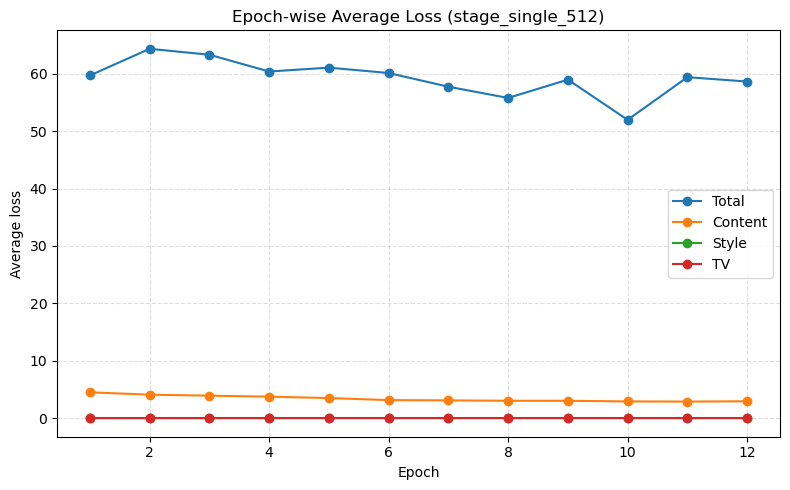

In [24]:
df_epoch = df.groupby("epoch", as_index=False).mean()

plt.figure(figsize=(8,5))
plt.plot(df_epoch["epoch"], df_epoch["total_loss"], "-o", label="Total")
plt.plot(df_epoch["epoch"], df_epoch["content_loss"], "-o", label="Content")
plt.plot(df_epoch["epoch"], df_epoch["style_loss"], "-o", label="Style")
plt.plot(df_epoch["epoch"], df_epoch["tv_loss"], "-o", label="TV")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.title(f"Epoch-wise Average Loss ({stage_name})")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
